# Projet 07 : Effectuer une prédiction de revenus

---
**Importation des librairies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.colors as plc
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
import modules_perso.sf_graphiques as sfg

---
## <font color=blue>Mission 4 : Modélisation du revenu des individus</font>

### 4.8.b. ANOVA du logarithme du revenu basée sur l'indice de Gini du pays et sur le logarithme du revenu des parents

In [4]:
data = pd.read_csv("data_analyse08.csv", index_col=0)
data.drop(columns="ln_revenu_moyen", inplace=True)
data.head()

C:\Anaconda3\envs\Jupyter\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,ln_child_income,gini_from_centiles,ln_parent_income
0,6.591534,32.141019,6.591534
1,6.591534,32.141019,6.591534
2,6.591534,32.141019,6.591534
3,6.591534,32.141019,6.591534
4,6.591534,32.141019,6.591534


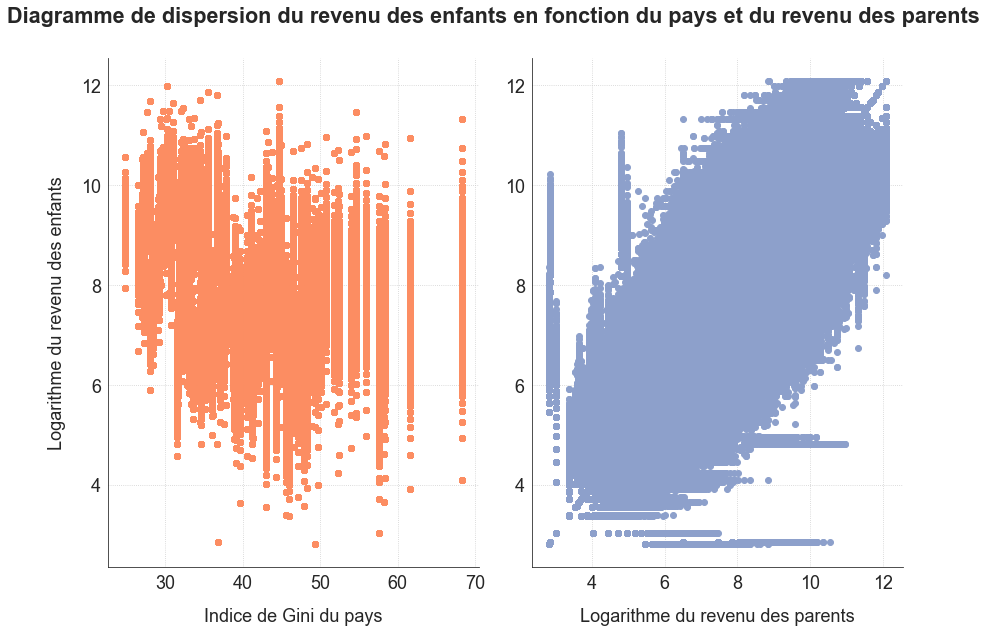

In [5]:
mygraph = sfg.MyGraph("Diagramme de dispersion du revenu des enfants en fonction du pays et du revenu des parents", nblin=1, nbcol=2, is_mono=False)
mygraph.add_plot(data.gini_from_centiles, data.ln_child_income, label="", marker='o', markeredgecolor=mygraph.liste_couleurs[1], markerfacecolor=mygraph.liste_couleurs[1], linestyle='', with_grid='both', grid_style=":", multi_index=1)
mygraph.add_plot(data.ln_parent_income, data.ln_child_income, label="", marker='o', color=mygraph.liste_couleurs[2], linestyle='', with_grid='both', grid_style=":", multi_index=2)
mygraph.set_axe('x', label="Indice de Gini du pays", multi_index=1)
mygraph.set_axe('x', label="Logarithme du revenu des parents", multi_index=2)
mygraph.set_axe('y', label="Logarithme du revenu des enfants", multi_index=1)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova09_00_diagramme_dispersion.png")
plt.show()

In [6]:
anova = smf.ols(formula="ln_child_income ~ gini_from_centiles + ln_parent_income", data=data).fit()

In [7]:
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ln_child_income   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                 8.422e+06
Date:                Mon, 14 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:57:38   Log-Likelihood:            -5.9403e+06
No. Observations:             5642420   AIC:                         1.188e+07
Df Residuals:                 5642417   BIC:                         1.188e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.5186      0.003    587.223      0.000       1.513       1.524
gini_from_centiles    -0.0079   3.47e-05   -229.146      0.000      -0.008      -0.008
ln_parent_income       0.8469      0.000   3783.896      0.000       0.846       0.847
==============================================================================
Omnibus:                   229189.862   Durbin-Watson:                   0.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           733423.896
Skew:                           0.064   Prob(JB):                         0.00
Kurtosis:                       4.762   Cond. No.                         367.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
gini_from_centiles,2.524638e+04,1.0,5.250797e+04,0.0,0.002624,0.002624
ln_parent_income,6.884182e+06,1.0,1.431787e+07,0.0,0.715436,0.715436
Residual,2.712933e+06,5642417.0,NaN,NaN,NaN,NaN
total,9.622361e+06,5642419.0,NaN,NaN,NaN,NaN


De façon logique, en supprimant la variable ln_parent_income, la part de dispersion expliquée par le modèle (R²) diminue à 74,9% de la dispersion totale. L'AIC et le BIC augmentent, ce qui marque également une détrioration du modèle.  
Il est intéressant de noter que le R² de cette variante est supérieure au R² du modèle 4 dont les variables exogènes étaient ln_revenu_moyen et l'indice de Gini. De même, l'AIC et le BIC sont inférieurs à ceux du modèle 4, ce qui marque également une amélioration du modèle.  
Il semble donc plus intéressant de prendre en considération dans le modèle le logarithme du revenu des parents plutôt que le logarithme du revenu moyen du pays.  
  
L'ANOVA conclut à la significativité des deux variables. La contribution de l'indice de Gini au modèle est très faible (omega squared = 0.003).

### Vérification des hypothèses

**Hypothèse 1 : Normalité des résidus**

In [9]:
alpha_normalite = 0.05
ad_stat, ad_pvalue = sm.stats.normal_ad(anova.resid)
norm_stat, norm_pvalue = st.kstest(anova.resid, cdf='norm', args=(anova.resid.mean(), anova.resid.var(ddof=1)))
jb_stat, jb_pvalue, skw, kurt = sm.stats.stattools.jarque_bera(anova.resid)
df_normalite = pd.DataFrame({'H0':np.repeat("Distribution normale",3), 'Statistique':["{:.2f}".format(ad_stat),"{:.2f}".format(norm_stat),"{:.2f}".format(jb_stat)], \
                             'p-value':["{:.3f}".format(ad_pvalue),"{:.3f}".format(norm_pvalue),"{:.3f}".format(jb_pvalue)]}, index=["Anderson-Darling","Kolmogorov-Smirnov","Jarque-Bera"])
inter_col = "Résultat (seuil={:.1%})".format(alpha_normalite)
df_normalite[inter_col] = ["Normalité acceptée" if float(pval)>=alpha_normalite else "Normalité rejetée" for pval in df_normalite["p-value"]]
df_normalite

C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\stats\_adnorm.py:66: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)
C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\stats\_adnorm.py:66: RuntimeWarning: divide by zero encountered in log
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)


,H0,Statistique,p-value,Résultat (seuil=5.0%)
Anderson-Darling,Distribution normale,inf,0.000,Normalité rejetée
Kolmogorov-Smirnov,Distribution normale,0.07,0.000,Normalité rejetée
Jarque-Bera,Distribution normale,733423.90,0.000,Normalité rejetée


Aucun des trois test n'accepte la normalité. Nous avons un grand nombre d'observations. Une symétrie de la distribution des résidus sera suffisante. Je vérifie graphiquement cette symétrie, et je trace également la droite de Henry.

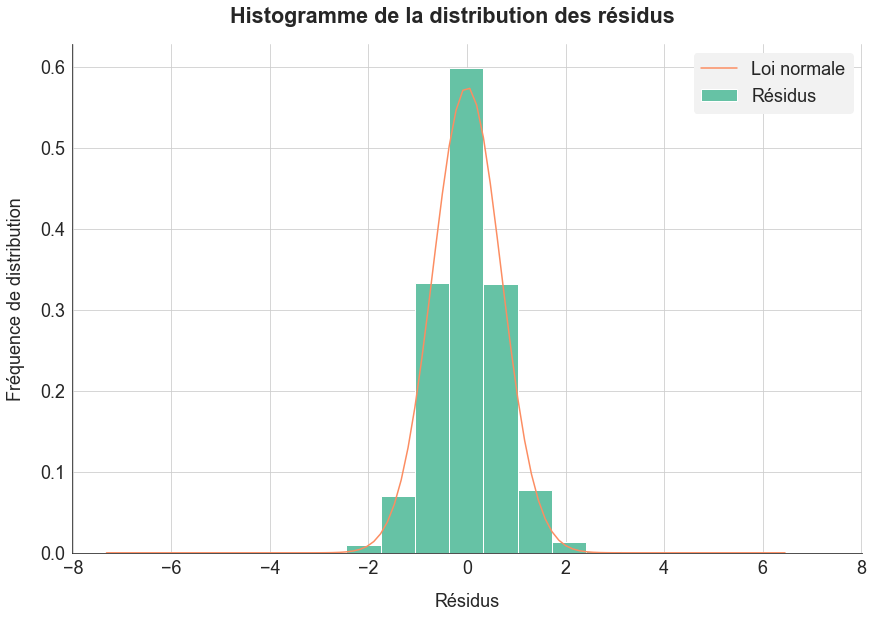

In [10]:
x_theo = np.arange(anova.resid.min(), anova.resid.max(), 0.01*(anova.resid.max()-anova.resid.min()))
mygraph = sfg.MyGraph("Histogramme de la distribution des résidus", is_mono=False)
mygraph.add_histogramme(anova.resid, bins=20, labels="Résidus")
mygraph.add_plot(x_theo, st.norm.pdf(x_theo, scale=anova.resid.std(ddof=1)), label="Loi normale", legend=True)
xmin, xmax = mygraph.ax[0].get_xlim()
absmax = max(-xmin, xmax)
mygraph.set_axe('y', label="Fréquence de distribution")
mygraph.set_axe('x', label="Résidus", tick_min=-absmax, tick_max=absmax)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova09_01_distribution_residus.png")
plt.show()

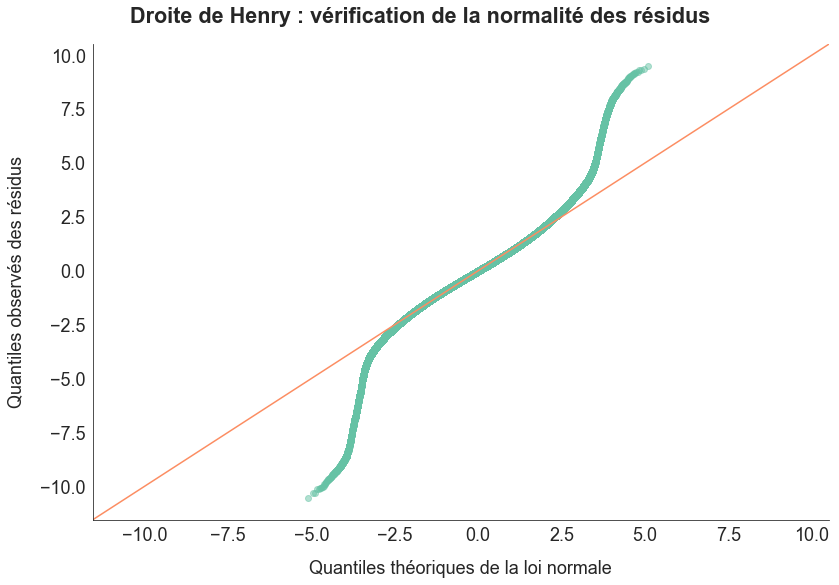

In [11]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova09_02_droite_henry.png")
plt.show()

On remarque que les résidus ne sont pas normaux. Par contre, ils présentent une symétrie presque parfaite.  
Même si les valeurs extrêmes des résidus ne sont toujours pas normales, elles semblent plus proche de la droite de Henry et donc de la distribution normale théorique.

**Hypothèse 2 : Linéarité et additivité de la relation  
Hypothèse 3 : Homoscédasticité des résidus**

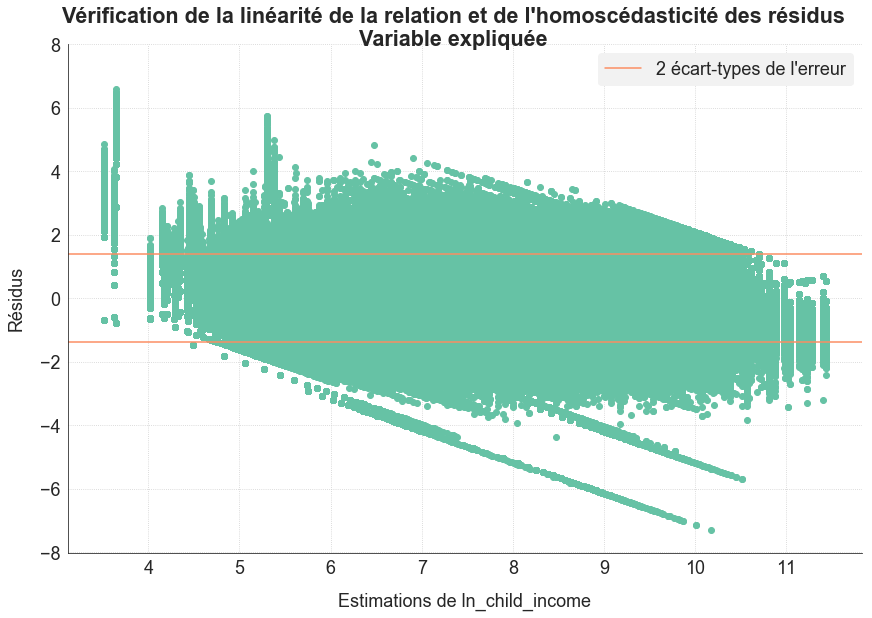

In [12]:
mygraph = sfg.MyGraph("Vérification de la linéarité de la relation et de l'homoscédasticité des résidus\nVariable expliquée", is_mono=False)
mygraph.add_plot(anova.fittedvalues, anova.resid, label="", marker='o', linestyle='', with_grid='both', grid_style=":")
yseuil = 2 * np.sqrt(table_anova.loc["Residual","sum_sq"] / table_anova.loc["Residual","df"])
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1])
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True)
ymin, ymax = mygraph.ax[0].get_ylim()
absmax = max(-ymin, ymax, 1.1*yseuil)
mygraph.set_axe('x', label="Estimations de ln_child_income")
mygraph.set_axe('y', label="Résidus", tick_min=-absmax, tick_max=absmax)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova09_03_linearite_homoscedasticite_endo.png")
plt.show()

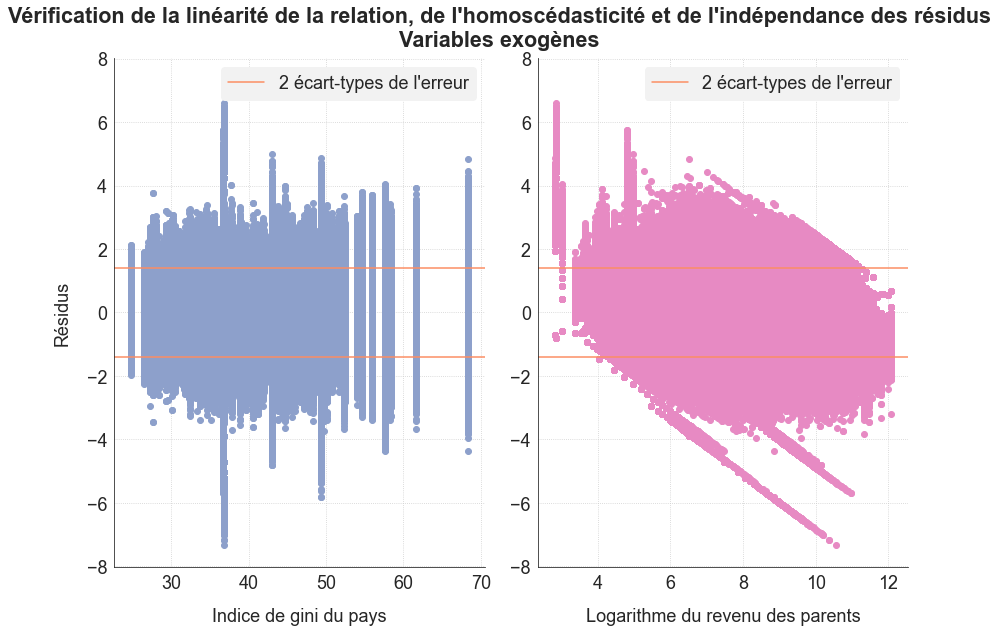

In [13]:
mygraph = sfg.MyGraph("Vérification de la linéarité de la relation, de l'homoscédasticité et de l'indépendance des résidus\nVariables exogènes", nblin=1, nbcol=2, is_mono=False)
mygraph.add_plot(data.gini_from_centiles, anova.resid, label="", marker='o', color=mygraph.liste_couleurs[2], linestyle='', with_grid='both', grid_style=":", multi_index=1)
mygraph.add_plot(data.ln_parent_income, anova.resid, label="", marker='o', color=mygraph.liste_couleurs[3], linestyle='', with_grid='both', grid_style=":", multi_index=2)
#yseuil = 2 * np.sqrt(table_anova.loc["Residual","sum_sq"] / table_anova.loc["Residual","df"])
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1], multi_index=1)
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True, multi_index=1)
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1], multi_index=2)
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True, multi_index=2)
ymin, ymax = mygraph.ax[0].get_ylim()
absmax = max(-ymin, ymax, 1.1*yseuil)
mygraph.set_axe('x', label="Indice de gini du pays", multi_index=1)
mygraph.set_axe('x', label="Logarithme du revenu des parents", multi_index=2)
mygraph.set_axe('y', label="Résidus", tick_min=-absmax, tick_max=absmax, multi_index=1)
mygraph.set_axe('y', tick_min=-absmax, tick_max=absmax, multi_index=2)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova09_04_linearite_homoscedasticite_exo.png")
plt.show()

In [14]:
# MEMORY ERROR - Graphiques précédents suffisants
alpha_homo = 0.05
lm_stat, lm_pvalue, f_stat, f_pvalue = sm.stats.diagnostic.het_breuschpagan(anova.resid, anova.model.exog)
if f_pvalue >= alpha_homo:
    test_result = ["Homoscédasticité acceptée"]
else:
    test_result = ["Homoscédasticité rejetée"]
pd.DataFrame({'H0':["Variance des résidus constante"], 'Statistique':["{:.2f}".format(f_stat)], \
             'p-value':["{:.3f}".format(f_pvalue)], 'Résultat (seuil={:.1%})'.format(alpha_homo):test_result}, index=["Breusch Pagan"])

,H0,Statistique,p-value,Résultat (seuil=5.0%)
Breusch Pagan,Variance des résidus constante,65161.23,0.000,Homoscédasticité rejetée


L'homoscédasticité est rejetée par le test. Par contre, les graphiques montrent que les résidus sont désormais assez bien répartis dans les valeurs positives et négatives. Les graphiques sont satisfaisants et permettent de valider les hypothèses d'homoscédasticité des résidus et de linéarité de la relation.  
Par rapport au modèle 4, nous n'avons plus de problème de croissance des résidus lorsque l'indice de Gini augmente. Mais nous avions remarqué que ce problème n'existait plus avec le modèle 7.  
Par contre, nous constatons que les résidus ne semblent pas indépendant du logarithme du revenu des parents. Cela semble logique. Car plus les revenus des parents sont élevés, plus l'estimation des revenus des enfants est élevée. Donc les enfants avec de forts revenus seront mal estimés (sous-estimés) lorsque leurs parents auront de faibles revenus (résidus fortement positifs pour de faibles valeurs du revenu des parents). Et inversement, les enfants avec de faibles revenus seront mal estimés (sur-estimés) lorsque leurs parents auront de forts revenus (résidus fortement négatifs pour des valeurs élevées du revenu des parents).

**Conclusion sur les hypothèses**

Les graphiques permettent d'accepter les hypothèses de normalité des résidus et d'homoroscédasticité. La dépendance des résidus avec le logarithme du revenu des parents se pose, mais elle s'explique facilement.

**Vérification supplémentaire : absence de colinéarité entre les exogènes**

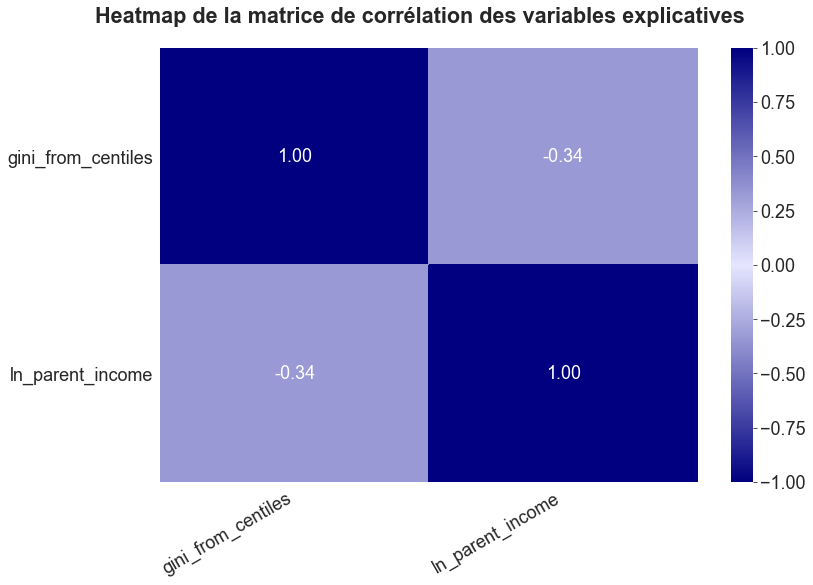

In [15]:
matrice_correl = np.corrcoef(data[["gini_from_centiles","ln_parent_income"]], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=["gini_from_centiles","ln_parent_income"], rotation=0)
mygraph.set_axe('x', tick_labels=["gini_from_centiles","ln_parent_income"], rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova09_05_matrice_correl.png")
plt.show()

In [16]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
gini_from_centiles,1.126564
ln_parent_income,1.126564


Aucun problème de colinéarité entre les 2 variables.

**Vérification de la pertinence des estimations par rapport aux valeurs réelles**

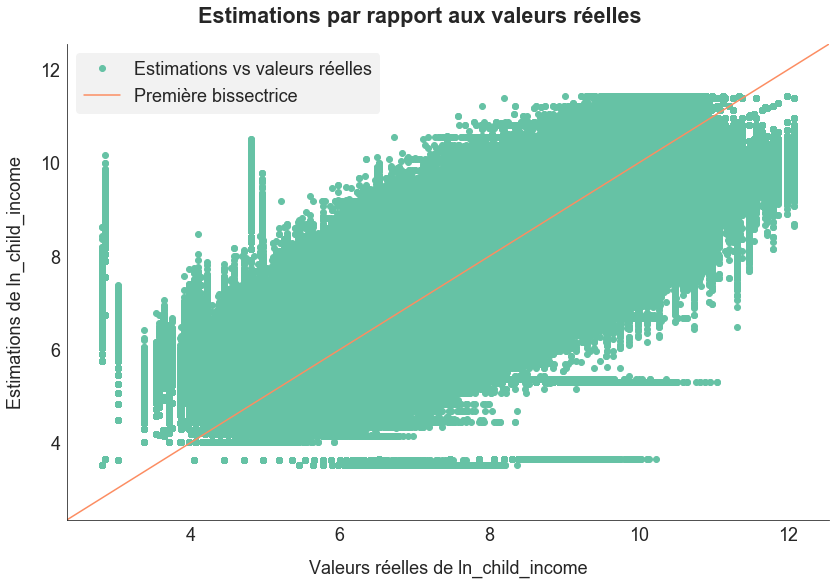

In [17]:
mygraph = sfg.MyGraph("Estimations par rapport aux valeurs réelles", is_mono=False)
mygraph.add_plot(data.ln_child_income, anova.fittedvalues, label="Estimations vs valeurs réelles", marker='o', linestyle="")
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="Première bissectrice", legend=True)
mygraph.set_axe('y', label="Estimations de ln_child_income")
mygraph.set_axe('x', label="Valeurs réelles de ln_child_income")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova09_06_accuracy_graph.png")
plt.show()

Certaines valeurs extrêmes sont moins bien expliquées par cette variante que par le modèle 4 ou par le modèle 7. Il est moins satisfaisant de ce point de vue.

**Analyse des outliers**

In [18]:
n, p = anova.model.exog.shape
p = p - 1  # j'enlève la constante du nombre de paramètres pour ajuster les seuils
seuils = pd.Series(index=["levier", "resid_student", "dffits", "cook","dfbetas"])
seuils.levier = 2 * (p + 1) / n
seuils.dffits = 2 * np.sqrt((p + 1) / n)
seuils.cook = 4 / (n - p - 1)
seuils.resid_student = st.t.ppf(1-(0.05/2), n-p-2)  # seuil de 5% pour les résidus studentisés
reg_influence = anova.get_influence()
analyses = pd.DataFrame({"observation_name":data.index})
analyses["levier"] = reg_influence.hat_matrix_diag
#analyses["external_resid_student"] = reg_influence.resid_studentized_external
#analyses["outlier"] = ((analyses.levier > seuils.levier) | (abs(analyses.external_resid_student) > seuils.resid_student))
analyses["outlier"] = analyses.levier > seuils.levier
#analyses["dffits"] = reg_influence.dffits[0]
analyses["cook_distance"] = reg_influence.cooks_distance[0]
analyses["influence"] = analyses.cook_distance > seuils.cook
#analyses["influence"] = (abs(analyses.dffits) > seuils.dffits) | (analyses.cook_distance > seuils.cook)

In [19]:
seuils[["levier","cook"]].to_frame().style.format("{:.8f}")

,0
levier,0.00000106
cook,0.00000071


In [20]:
only_both = False
if only_both == False:
    print("Résumé des observations atypiques OU influentes")
    variables_speciales = analyses[(analyses.outlier | analyses.influence) & (analyses.outlier != analyses.influence)]
    print(variables_speciales)
    print("")
print("Résumé des observations atypiques ET influentes")
variables_investigation = analyses[analyses.outlier & analyses.influence]
variables_investigation

Résumé des observations atypiques OU influentes
         observation_name        levier  outlier  cook_distance  influence
19441               19441  5.445906e-07    False   1.316633e-06       True
20441               20441  5.445906e-07    False   1.287146e-06       True
25423               25423  5.445906e-07    False   1.116520e-06       True
26908               26908  5.445906e-07    False   1.062298e-06       True
26909               26909  5.445906e-07    False   1.062298e-06       True
27403               27403  5.445906e-07    False   1.048590e-06       True
27404               27404  5.445906e-07    False   1.048590e-06       True
27405               27405  5.445906e-07    False   1.048590e-06       True
27909               27909  5.445906e-07    False   1.031380e-06       True
27910               27910  5.445906e-07    False   1.031380e-06       True
28909               28909  5.445906e-07    False   9.993499e-07       True
28910               28910  5.445906e-07    False   9

,observation_name,levier,outlier,cook_distance,influence
72692,72692,0.000001,True,0.000004,True
73693,73693,0.000001,True,0.000003,True
74185,74185,0.000001,True,0.000003,True
78178,78178,0.000001,True,0.000003,True
78179,78179,0.000001,True,0.000003,True
78675,78675,0.000001,True,0.000003,True
78676,78676,0.000001,True,0.000003,True
79667,79667,0.000001,True,0.000003,True
80168,80168,0.000001,True,0.000002,True
82173,82173,0.000001,True,0.000002,True


Le nombre d'observations atypiques ou/et influentes diminue légèrement par rapport au modèle 7 de base.

**Conclusion sur cette variante**

La dépendance des résidus avec le logarithme du revenu des parents pose un vrai problème.  
L'autre point négatif est la mauvaise estimation des valeurs extrêmes par rapport aux modèles précédents.  
  
Ces deux points amènent à rejeter cette variante.